### Imports

In [1]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import numpy as np
import pandas as pd
from datetime import datetime

import backtrader as bt
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
import sys

sys.path.append('./Strategies')
sys.path.append('./DataFeeds')

from glove import *
#from buy_and_hold_strats import *
from random_strats import *
from mean_ou_strats import *
from high_mid_low_strats import *

### Strategy Testing

In [3]:
#Bracket Orders BUY + Cloase each day
class HighMidLow(bt.Strategy):
    
    params = dict(
        stop_loss = 0.92,  # price is 2% less than the entry point
        take_profit = 10.04,
        orders = dict(),
        msg='',
        data = pd.DataFrame(columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(sep=' ', timespec='auto'), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.sentiment = self.datas[0].sentiment_mean
        self.size = self.data.buflen()
        self.order = None
        self.stop_order = None
        self.tp_order = None
        self.total_position = 0
    
    def update_dataset(self, order, close = False):
        if not close:
            pos = 1 if order.isbuy() else -1
            data_new_line = pd.DataFrame(
                [[
                    self.datas[0].datetime.datetime(0), 
                    pos, 
                    order.size*order.executed.price,
                    order.executed.price,
                    self.data.sentiment_mean[-1],
                    None,
                    None
                ]], 
                columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
            self.p.data = pd.concat([self.p.data,data_new_line], axis = 0, ignore_index=False)
        else:
            self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(-1)
            self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = order.executed.price
    def notify_order(self, order):
        
        # Save submitted order
        if order.status in [order.Submitted, order.Accepted]:
            self.p.orders[order.ref] = order
            return
        
        # Check if an order has been completed
        if order.status in [order.Completed]:
            

            if not self.position:
                print('(CLOSE)', end='')
            else:
                self.log(self.p.msg)
            #print(self.p.data)
            if order.isbuy():
                self.update_dataset(order)
                self.log('BUY EXECUTED, ' + str(order.size) + 'BTC AT ' +str(order.executed.price))
            elif order.issell():
                self.update_dataset(order, close = True)
                self.log('SELL EXECUTED, ' + str(order.size) + 'BTC AT ' + str(order.executed.price))
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log('Not Enough Margin')
            elif order.status == order.Rejected:
                self.log('Order Rejected')

        self.order = None

    def broker_val_diff(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1] - self.datas[0].rolling_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean - self.datas[0].rolling_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    #high sqn big diff
    def broker_val(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    def pure(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        return sentiment
    
    def single(self):
         return self.broker.getvalue()*(self.datas[0].sentiment_mean)/self.datas[0].open
            
    #no difference
    def standar(self):
        return self.broker.getvalue()*0.05/self.datas[0].open
    
    def next(self):
        #print(self.data.sentiment_mean[0], self.data.open[0],self.data.close[0], self.data.volume[0])

        if self.order:
            return
        #if not self.position.size:
        # this is to play only on periods with sentiment data
        if self.datas[0].sentiment_mean > -2.0:
            # High
#             if self.datas[0].sentiment_mean >= self.datas[0].rolling_mean:
            if self.datas[0].sentiment_weighted_mean >= 0.00:
            # Mid
#             if self.datas[0].sentiment_mean < 0.7 and self.datas[0].sentiment_mean > 0.633:
            # Low
#             if self.datas[0].sentiment_mean <= 0.633:
                #print(self.broker.getvalue(), self.broker.getcash())
                
        
                #position sizing
                #pos_size = self.broker_val_diff()
#                 pos_size = self.single()
                     
#              
                if self.position.size:
                    self.close(exectype=bt.Order.Market, coc = True)
#                 pos_size = abs(self.datas[0].sentiment_weighted_mean)/self.datas[0].open[0]
                #stop loss price
                sl_price = self.datas[0].open[0]*(1-self.p.stop_loss)
                #take profit price
                tp_price = self.datas[0].open[0]*(1+self.p.take_profit)
#             if pos_size>0:
#                     #Debug message
#                     self.p.msg = 'BUY CREATED AT ' + str(self.datas[0].open[0]) +' STOPLOSS SET AT ' + str(sl_price)+ '$ TAKE PROFIT AT '+ str(tp_price)+'$'
#                     #self.buy(exectype=bt.Order.Market, size = pos_size)

                #Bracket order buy
                self.order = self.buy_bracket(exectype=bt.Order.Market, 
                                     stopprice = sl_price,
                                     limitprice = tp_price,
                                     coc=False)

#                 new_pos = pos_size - self.position.size
#                 if new_pos > 0:
#                     self.order = self.buy(exectype=bt.Order.Market, size = abs(new_pos))
#                 elif new_pos < 0:
#                     self.order = self.sell(exectype=bt.Order.Market, size = abs(new_pos))
        #Close all positions at the Close of the day
            
        if self.position.size:
            #self.log(str(len(self))+' '+str(self.size))
            if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d'):
            #if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d %H')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d %H'):
                self.order = self.close(exectype=bt.Order.Market, coc = True)
                # and Cancel all pending orders
                for o in self.p.orders:
                    order = self.p.orders[o]
                    if order.alive :
                        self.cancel(order)
                self.p.orders = dict()
                
                if len(self) == self.size:
                     self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(0)
                     self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = self.datas[0].close[0]
                

In [30]:
#Bracket Orders BUY + Cloase each day
class HighMidLow(bt.Strategy):
    
    params = dict(
        stop_loss = 0.92,  # price is 2% less than the entry point
        take_profit = 10.04,
        orders = dict(),
        msg='',
        data = pd.DataFrame(columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(sep=' ', timespec='auto'), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.sentiment = self.datas[0].sentiment_mean
        self.size = self.data.buflen()
        self.order = None
        self.stop_order = None
        self.tp_order = None
        self.total_position = 0
    
    def update_dataset(self, order, close = False):
        if not close:
            pos = 1 if order.isbuy() else -1
            data_new_line = pd.DataFrame(
                [[
                    self.datas[0].datetime.datetime(0), 
                    pos, 
                    order.size*order.executed.price,
                    order.executed.price,
                    self.data.sentiment_mean[-1],
                    None,
                    None
                ]], 
                columns = ['entry_time', 'position', 'weight', 'entry_price', 'sentiment', 'exit_time', 'exit_price'])
            self.p.data = pd.concat([self.p.data,data_new_line], axis = 0, ignore_index=False)
        else:
            self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(-1)
            self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = order.executed.price
    def notify_order(self, order):
        
        # Save submitted order
        if order.status in [order.Submitted, order.Accepted]:
            self.p.orders[order.ref] = order
            return
        
        # Check if an order has been completed
        if order.status in [order.Completed]:
            

            if not self.position:
                print('(CLOSE)', end='')
            else:
                self.log(self.p.msg)
            #print(self.p.data)
            if order.isbuy():
                self.update_dataset(order)
                self.log('BUY EXECUTED, ' + str(order.size) + 'BTC AT ' +str(order.executed.price))
            elif order.issell():
                self.update_dataset(order, close = True)
                self.log('SELL EXECUTED, ' + str(order.size) + 'BTC AT ' + str(order.executed.price))
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            if order.status == order.Canceled:
                self.log('Order Canceled')
            elif order.status == order.Margin:
                self.log('Not Enough Margin')
            elif order.status == order.Rejected:
                self.log('Order Rejected')

        self.order = None

    def broker_val_diff(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1] - self.datas[0].rolling_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean - self.datas[0].rolling_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    #high sqn big diff
    def broker_val(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        pos_size = self.broker.getvalue()*(sentiment)/self.datas[0].open[0]
        return pos_size
    
    def pure(self):
        prev_sentiment = 0
        if len(self) > 0:
            prev_sentiment = self.datas[0].sentiment_mean[-1]
        this_sentiment = self.datas[0].sentiment_mean
        sentiment = this_sentiment - prev_sentiment
        return sentiment
    
    def single(self):
         return self.broker.getvalue()*(self.datas[0].sentiment_mean)/self.datas[0].open
            
    #no difference
    def standar(self):
        return self.broker.getvalue()*0.05/self.datas[0].open
    
    def next(self):
        #print(self.data.sentiment_mean[0], self.data.open[0],self.data.close[0], self.data.volume[0])

        if self.order:
            return
        #if not self.position.size:
        # this is to play only on periods with sentiment data
        if self.datas[0].sentiment_mean > -2.0:
            # High
#             if self.datas[0].sentiment_mean >= self.datas[0].rolling_mean:
            if self.datas[0].sentiment_weighted_mean <= 0.0 and not self.position.size:
                sl_price = self.datas[0].open[0]*(1-self.p.stop_loss)
                #take profit price
                tp_price = self.datas[0].open[0]*(1+self.p.take_profit)
#               if pos_size>0:
#                     #Debug message
#                     self.p.msg = 'BUY CREATED AT ' + str(self.datas[0].open[0]) +' STOPLOSS SET AT ' + str(sl_price)+ '$ TAKE PROFIT AT '+ str(tp_price)+'$'
#                     #self.buy(exectype=bt.Order.Market, size = pos_size)

                #Bracket order buy
                self.order = self.buy_bracket(exectype=bt.Order.Market, 
                                     stopprice = sl_price,
                                     limitprice = tp_price,
                                     coc=False)
               
            
        if self.position.size:
            #self.log(str(len(self))+' '+str(self.size))
            if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d'):
            #if len(self) == self.size or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d %H')!=self.datas[0].datetime.datetime(1).strftime('%Y-%m-%d %H'):
                self.order = self.close(exectype=bt.Order.Market, coc = True)
                # and Cancel all pending orders
                for o in self.p.orders:
                    order = self.p.orders[o]
                    if order.alive :
                        self.cancel(order)
                self.p.orders = dict()
                
                if len(self) == self.size:
                     self.p.data.loc[self.p.data['exit_time'].isna() ,'exit_time'] = self.datas[0].datetime.datetime(0)
                     self.p.data.loc[self.p.data['exit_price'].isna() ,'exit_price'] = self.datas[0].close[0]
                

### Running Backtest

In [31]:
x = pd.read_csv('../Data Preprocessed/glove_1M_full_dates_hour.csv')
x.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12959 entries, 0 to 12958
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hour               12959 non-null  object 
 1   Open               12959 non-null  float64
 2   Close              12959 non-null  float64
 3   High               12959 non-null  float64
 4   Low                12959 non-null  float64
 5   Volume_(Currency)  12959 non-null  float64
 6   Bitcoin            11989 non-null  float64
 7   Bitcoin_weighted   11989 non-null  float64
dtypes: float64(7), object(1)
memory usage: 810.1+ KB


In [32]:
# x.loc[x['Bitcoin'].isna(),'Bitcoin'] = 7
x

,hour,Open,Close,High,Low,Volume_(Currency),Bitcoin,Bitcoin_weighted
0,2017-08-01 00:00:00,2855.81,2825.92,2863.06,2823.00,5.761686e+05,0.551378,0.006434
1,2017-08-01 01:00:00,2823.01,2853.38,2860.02,2821.01,2.305357e+05,0.542253,0.003526
2,2017-08-01 02:00:00,2846.27,2841.60,2858.04,2837.31,4.106376e+05,0.558104,0.036610
3,2017-08-01 03:00:00,2841.84,2862.93,2863.88,2837.73,7.004128e+05,0.543261,0.019883
4,2017-08-01 04:00:00,2862.92,2872.03,2876.00,2848.11,7.303088e+05,0.548800,0.017027
...,...,...,...,...,...,...,...,...
12954,2019-01-22 18:00:00,3591.48,3590.67,3592.24,3575.93,8.446970e+05,0.536790,0.007699
12955,2019-01-22 19:00:00,3589.30,3579.28,3615.80,3573.00,2.241047e+06,0.526050,0.001949
12956,2019-01-22 20:00:00,3579.28,3585.51,3592.28,3579.28,5.052538e+05,0.539084,0.016331
12957,2019-01-22 21:00:00,3586.72,3574.26,3592.28,3573.99,4.213898e+05,0.510615,-0.016327


In [33]:
class glove_1M_full_dates_hour_rolling_mean_feed(btfeeds.GenericCSVData):
    lines = ( 'sentiment_mean','sentiment_weighted_mean', 'rolling_mean', 'rolling_mean_weighted',)
    params = (
        ('nullvalue', -2),
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('datetime', 0),
        ('open', 1),
        ('close', 2),
        ('low', 4),
        ('high', 3),
        ('volume', 5),
        ('sentiment_mean', 6),
        ('sentiment_weighted_mean', 7),
        ('rolling_mean', 10),
        ('rolling_mean_weighted', 11),
        ('time', -1),
        ('openinterest', -1),
    )

In [34]:
import pathlib
import backtrader.analyzers as btanalyzers
# Create a cerebro entity
cerebro = bt.Cerebro(cheat_on_open=True)

# Add a strategy
#strat = Random
# strat = TestStrategy
# strat = BuyAndHold
strat = HighMidLow
# strat = OverUnderMean
cerebro.addstrategy(strat)
# strat = BuyAndHold
# cerebro.addstrategy(strat)

#data = glove_100k_91_min_feed(dataname = '../Data Preprocessed/glove_100k_91_min.csv', timeframe = bt.TimeFrame.Minutes, compression = 1)
# data = glove_1M_full_dates_min_feed(dataname = '../Data Preprocessed/glove_1M_full_dates_min.csv', timeframe = bt.TimeFrame.Minutes, compression = 1)
#data = glove_1M_full_dates_hour_feed(dataname = '../Data Preprocessed/glove_1M_full_dates_hour.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
#data = final_dataset_feed(dataname = '../final_dataset3.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
data = glove_1M_full_dates_hour_rolling_mean_feed(dataname = './glove_1M_full_dates_hour_rolling_mean.csv', timeframe = bt.TimeFrame.Minutes, compression = 60)
cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_coc(True)
# Add the Data Feed to Cerebro
cerebro.adddata(data)

#sizers
# cerebro.addsizer(bt.sizers.AllInSizer)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 95)
# cerebro.addsizer(bt.sizers.PercentSizer, percents = 0.01)
# cerebro.addsizer(bt.sizers.SizerFix, stake=0.1)

#observers
cerebro.addobserver(bt.observers.BuySell)

#analyzers
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.SQN, _name='sqn')

#cerebro.add_order_history(orders, notify=True)

# Set our desired cash start
cerebro.broker.setcash(1)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

returns_high, positions_high, transactions_high, gross_lev_high = pyfoliozer.get_pf_items()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1.00
2017-08-01 06:00:00, 
2017-08-01 06:00:00, BUY EXECUTED, 0.0003275862068965517BTC AT 2895.02
2017-08-02 00:00:00, Order Canceled
2017-08-02 00:00:00, Order Canceled
(CLOSE)2017-08-02 00:00:00, SELL EXECUTED, -0.0003275862068965517BTC AT 2731.0
2017-08-02 09:00:00, 
2017-08-02 09:00:00, BUY EXECUTED, 0.0003303806527920507BTC AT 2719.31
2017-08-03 00:00:00, Order Canceled
2017-08-03 00:00:00, Order Canceled
(CLOSE)2017-08-03 00:00:00, SELL EXECUTED, -0.0003303806527920507BTC AT 2703.51
2017-08-03 04:00:00, 
2017-08-03 04:00:00, BUY EXECUTED, 0.00032866322239225677BTC AT 2718.05
2017-08-04 00:00:00, Order Canceled
2017-08-04 00:00:00, Order Canceled
(CLOSE)2017-08-04 00:00:00, SELL EXECUTED, -0.00032866322239225677BTC AT 2793.37
2017-08-04 01:00:00, 
2017-08-04 01:00:00, BUY EXECUTED, 0.00032820753111010545BTC AT 2794.02
2017-08-05 00:00:00, Order Canceled
2017-08-05 00:00:00, Order Canceled
(CLOSE)2017-08-05 00:00:00, SELL EXECUTED, -0.00032820753111010545B

2017-09-23 19:00:00, 
2017-09-23 19:00:00, BUY EXECUTED, 0.0003306956509318474BTC AT 3742.6500000000005
2017-09-24 00:00:00, Order Canceled
2017-09-24 00:00:00, Order Canceled
(CLOSE)2017-09-24 00:00:00, SELL EXECUTED, -0.0003306956509318474BTC AT 3779.17
2017-09-24 13:00:00, 
2017-09-24 13:00:00, BUY EXECUTED, 0.00033864252009535627BTC AT 3690.02
2017-09-25 00:00:00, Order Canceled
2017-09-25 00:00:00, Order Canceled
(CLOSE)2017-09-25 00:00:00, SELL EXECUTED, -0.00033864252009535627BTC AT 3664.22
2017-09-25 04:00:00, 
2017-09-25 04:00:00, BUY EXECUTED, 0.0003297937606166885BTC AT 3766.48
2017-09-26 00:00:00, Order Canceled
2017-09-26 00:00:00, Order Canceled
(CLOSE)2017-09-26 00:00:00, SELL EXECUTED, -0.0003297937606166885BTC AT 3918.0
2017-09-26 07:00:00, 
2017-09-26 07:00:00, BUY EXECUTED, 0.00033098240957040034BTC AT 3893.7499999999995
2017-09-27 00:00:00, Order Canceled
2017-09-27 00:00:00, Order Canceled
(CLOSE)2017-09-27 00:00:00, SELL EXECUTED, -0.00033098240957040034BTC AT 388

2017-11-12 00:00:00, Order Canceled
2017-11-12 00:00:00, Order Canceled
(CLOSE)2017-11-12 00:00:00, SELL EXECUTED, -0.0002915237841293765BTC AT 6355.13
2017-11-12 01:00:00, 
2017-11-12 01:00:00, BUY EXECUTED, 0.0002973399868074931BTC AT 6246.0
2017-11-13 00:00:00, Order Canceled
2017-11-13 00:00:00, Order Canceled
(CLOSE)2017-11-13 00:00:00, SELL EXECUTED, -0.0002973399868074931BTC AT 5870.37
2017-11-13 01:00:00, 
2017-11-13 01:00:00, BUY EXECUTED, 0.00029056595085424496BTC AT 6030.66
2017-11-14 00:00:00, Order Canceled
2017-11-14 00:00:00, Order Canceled
(CLOSE)2017-11-14 00:00:00, SELL EXECUTED, -0.00029056595085424496BTC AT 6525.17
2017-11-14 02:00:00, 
2017-11-14 02:00:00, BUY EXECUTED, 0.0002848823710980292BTC AT 6630.01
2017-11-15 00:00:00, Order Canceled
2017-11-15 00:00:00, Order Canceled
(CLOSE)2017-11-15 00:00:00, SELL EXECUTED, -0.0002848823710980292BTC AT 6609.0
2017-11-15 01:00:00, 
2017-11-15 01:00:00, BUY EXECUTED, 0.00027897624433780103BTC AT 6734.66
2017-11-16 00:00:00

2017-12-29 00:00:00, Order Canceled
2017-12-29 00:00:00, Order Canceled
(CLOSE)2017-12-29 00:00:00, SELL EXECUTED, -0.00028415896615790256BTC AT 14470.069999999998
2017-12-29 01:00:00, 
2017-12-29 01:00:00, BUY EXECUTED, 0.00028655155087342003BTC AT 14375.0
2017-12-30 00:00:00, Order Canceled
2017-12-30 00:00:00, Order Canceled
(CLOSE)2017-12-30 00:00:00, SELL EXECUTED, -0.00028655155087342003BTC AT 14340.0
2017-12-30 01:00:00, 
2017-12-30 01:00:00, BUY EXECUTED, 0.0002870082674909185BTC AT 14280.01
2017-12-31 00:00:00, Order Canceled
2017-12-31 00:00:00, Order Canceled
(CLOSE)2017-12-31 00:00:00, SELL EXECUTED, -0.0002870082674909185BTC AT 12640.0
2018-01-01 03:00:00, 
2018-01-01 03:00:00, BUY EXECUTED, 0.0002718962469834809BTC AT 13407.98
2018-01-02 00:00:00, Order Canceled
2018-01-02 00:00:00, Order Canceled
(CLOSE)2018-01-02 00:00:00, SELL EXECUTED, -0.0002718962469834809BTC AT 13443.41
2018-01-02 08:00:00, 
2018-01-02 08:00:00, BUY EXECUTED, 0.00027268067233784964BTC AT 13424.01
2

2018-02-27 03:00:00, BUY EXECUTED, 0.0003254760732627621BTC AT 10170.0
2018-02-28 00:00:00, Order Canceled
2018-02-28 00:00:00, Order Canceled
(CLOSE)2018-02-28 00:00:00, SELL EXECUTED, -0.0003254760732627621BTC AT 10566.3
2018-02-28 01:00:00, 
2018-02-28 01:00:00, BUY EXECUTED, 0.0003223004353151995BTC AT 10640.86
2018-03-01 00:00:00, Order Canceled
2018-03-01 00:00:00, Order Canceled
(CLOSE)2018-03-01 00:00:00, SELL EXECUTED, -0.0003223004353151995BTC AT 10314.9
2018-03-01 01:00:00, 
2018-03-01 01:00:00, BUY EXECUTED, 0.00032080381075395956BTC AT 10388.99
2018-03-02 00:00:00, Order Canceled
2018-03-02 00:00:00, Order Canceled
(CLOSE)2018-03-02 00:00:00, SELL EXECUTED, -0.00032080381075395956BTC AT 10903.13
2018-03-03 00:00:00, 
2018-03-03 00:00:00, BUY EXECUTED, 0.00031636644725722935BTC AT 11032.81
2018-03-04 00:00:00, Order Canceled
2018-03-04 00:00:00, Order Canceled
(CLOSE)2018-03-04 00:00:00, SELL EXECUTED, -0.00031636644725722935BTC AT 11445.0
2018-03-05 00:00:00, 
2018-03-05 0

2018-04-17 04:00:00, BUY EXECUTED, 0.00035430269850953957BTC AT 8033.589999999999
2018-04-18 00:00:00, Order Canceled
2018-04-18 00:00:00, Order Canceled
(CLOSE)2018-04-18 00:00:00, SELL EXECUTED, -0.00035430269850953957BTC AT 7890.869999999999
2018-04-18 01:00:00, 
2018-04-18 01:00:00, BUY EXECUTED, 0.0003535150227190781BTC AT 7909.419999999999
2018-04-19 00:00:00, Order Canceled
2018-04-19 00:00:00, Order Canceled
(CLOSE)2018-04-19 00:00:00, SELL EXECUTED, -0.0003535150227190781BTC AT 8172.84
2018-04-19 01:00:00, 
2018-04-19 01:00:00, BUY EXECUTED, 0.0003534837883869713BTC AT 8160.1
2018-04-20 00:00:00, Order Canceled
2018-04-20 00:00:00, Order Canceled
(CLOSE)2018-04-20 00:00:00, SELL EXECUTED, -0.0003534837883869713BTC AT 8271.31
2018-04-20 04:00:00, 
2018-04-20 04:00:00, BUY EXECUTED, 0.00035069005440738487BTC AT 8331.99
2018-04-21 00:00:00, Order Canceled
2018-04-21 00:00:00, Order Canceled
(CLOSE)2018-04-21 00:00:00, SELL EXECUTED, -0.00035069005440738487BTC AT 8861.0
2018-04-21

2018-06-04 12:00:00, 
2018-06-04 12:00:00, BUY EXECUTED, 0.00039871950993063956BTC AT 7518.99
2018-06-05 00:00:00, Order Canceled
2018-06-05 00:00:00, Order Canceled
(CLOSE)2018-06-05 00:00:00, SELL EXECUTED, -0.00039871950993063956BTC AT 7488.26
2018-06-05 04:00:00, 
2018-06-05 04:00:00, BUY EXECUTED, 0.0004025636733983824BTC AT 7408.42
2018-06-06 00:00:00, Order Canceled
2018-06-06 00:00:00, Order Canceled
(CLOSE)2018-06-06 00:00:00, SELL EXECUTED, -0.0004025636733983824BTC AT 7617.98
2018-06-06 07:00:00, 
2018-06-06 07:00:00, BUY EXECUTED, 0.00040099458770145397BTC AT 7632.02
2018-06-07 00:00:00, Order Canceled
2018-06-07 00:00:00, Order Canceled
(CLOSE)2018-06-07 00:00:00, SELL EXECUTED, -0.00040099458770145397BTC AT 7658.569999999999
2018-06-07 14:00:00, 
2018-06-07 14:00:00, BUY EXECUTED, 0.0003990915741038608BTC AT 7698.94
2018-06-08 00:00:00, Order Canceled
2018-06-08 00:00:00, Order Canceled
(CLOSE)2018-06-08 00:00:00, SELL EXECUTED, -0.0003990915741038608BTC AT 7689.28
2018-0

(CLOSE)2018-07-21 00:00:00, SELL EXECUTED, -0.00039535418545830214BTC AT 7330.84
2018-07-21 14:00:00, 
2018-07-21 14:00:00, BUY EXECUTED, 0.0003943003121566672BTC AT 7352.0
2018-07-22 00:00:00, Order Canceled
2018-07-22 00:00:00, Order Canceled
(CLOSE)2018-07-22 00:00:00, SELL EXECUTED, -0.0003943003121566672BTC AT 7409.92
2018-07-22 06:00:00, 
2018-07-22 06:00:00, BUY EXECUTED, 0.0003946274717927848BTC AT 7398.32
2018-07-23 00:00:00, Order Canceled
2018-07-23 00:00:00, Order Canceled
(CLOSE)2018-07-23 00:00:00, SELL EXECUTED, -0.0003946274717927848BTC AT 7396.6
2018-07-23 02:00:00, 
2018-07-23 02:00:00, BUY EXECUTED, 0.00038857136374593874BTC AT 7518.64
2018-07-24 00:00:00, Order Canceled
2018-07-24 00:00:00, Order Canceled
(CLOSE)2018-07-24 00:00:00, SELL EXECUTED, -0.00038857136374593874BTC AT 7719.62
2018-07-24 01:00:00, 
2018-07-24 01:00:00, BUY EXECUTED, 0.0003878846539870858BTC AT 7720.680000000001
2018-07-25 00:00:00, Order Canceled
2018-07-25 00:00:00, Order Canceled
(CLOSE)20

2018-09-08 00:00:00, Order Canceled
2018-09-08 00:00:00, Order Canceled
(CLOSE)2018-09-08 00:00:00, SELL EXECUTED, -0.000434545162988918BTC AT 6400.0
2018-09-08 03:00:00, 
2018-09-08 03:00:00, BUY EXECUTED, 0.00043255741677515033BTC AT 6432.13
2018-09-09 00:00:00, Order Canceled
2018-09-09 00:00:00, Order Canceled
(CLOSE)2018-09-09 00:00:00, SELL EXECUTED, -0.00043255741677515033BTC AT 6178.31
2018-09-09 01:00:00, 
2018-09-09 01:00:00, BUY EXECUTED, 0.000433138157061529BTC AT 6182.9
2018-09-10 00:00:00, Order Canceled
2018-09-10 00:00:00, Order Canceled
(CLOSE)2018-09-10 00:00:00, SELL EXECUTED, -0.000433138157061529BTC AT 6236.04
2018-09-10 01:00:00, 
2018-09-10 01:00:00, BUY EXECUTED, 0.00043244322402515695BTC AT 6249.07
2018-09-11 00:00:00, Order Canceled
2018-09-11 00:00:00, Order Canceled
(CLOSE)2018-09-11 00:00:00, SELL EXECUTED, -0.00043244322402515695BTC AT 6301.99
2018-09-11 01:00:00, 
2018-09-11 01:00:00, BUY EXECUTED, 0.00043134212749230646BTC AT 6309.86
2018-09-12 00:00:00,

2018-10-26 01:00:00, BUY EXECUTED, 0.00043698217481476784BTC AT 6400.18
2018-10-27 00:00:00, Order Canceled
2018-10-27 00:00:00, Order Canceled
(CLOSE)2018-10-27 00:00:00, SELL EXECUTED, -0.00043698217481476784BTC AT 6406.1
2018-10-27 01:00:00, 
2018-10-27 01:00:00, BUY EXECUTED, 0.00043706159349336197BTC AT 6407.85
2018-10-28 00:00:00, Order Canceled
2018-10-28 00:00:00, Order Canceled
(CLOSE)2018-10-28 00:00:00, SELL EXECUTED, -0.00043706159349336197BTC AT 6407.66
2018-10-28 01:00:00, 
2018-10-28 01:00:00, BUY EXECUTED, 0.00043711957397678887BTC AT 6403.61
2018-10-29 00:00:00, Order Canceled
2018-10-29 00:00:00, Order Canceled
(CLOSE)2018-10-29 00:00:00, SELL EXECUTED, -0.00043711957397678887BTC AT 6405.57
2018-10-29 01:00:00, 
2018-10-29 01:00:00, BUY EXECUTED, 0.00043729379619024953BTC AT 6404.07
2018-10-30 00:00:00, Order Canceled
2018-10-30 00:00:00, Order Canceled
(CLOSE)2018-10-30 00:00:00, SELL EXECUTED, -0.00043729379619024953BTC AT 6266.52
2018-10-30 04:00:00, 
2018-10-30 04

2018-12-14 00:00:00, Order Canceled
2018-12-14 00:00:00, Order Canceled
(CLOSE)2018-12-14 00:00:00, SELL EXECUTED, -0.0004806501328284457BTC AT 3262.73
2018-12-14 01:00:00, 
2018-12-14 01:00:00, BUY EXECUTED, 0.00048016122479883964BTC AT 3272.71
2018-12-15 00:00:00, Order Canceled
2018-12-15 00:00:00, Order Canceled
(CLOSE)2018-12-15 00:00:00, SELL EXECUTED, -0.00048016122479883964BTC AT 3195.75
2018-12-15 02:00:00, 
2018-12-15 02:00:00, BUY EXECUTED, 0.0004788945187622183BTC AT 3205.25
2018-12-16 00:00:00, Order Canceled
2018-12-16 00:00:00, Order Canceled
(CLOSE)2018-12-16 00:00:00, SELL EXECUTED, -0.0004788945187622183BTC AT 3179.54
2018-12-16 07:00:00, 
2018-12-16 07:00:00, BUY EXECUTED, 0.0004713218006844486BTC AT 3233.58
2018-12-17 00:00:00, Order Canceled
2018-12-17 00:00:00, Order Canceled
(CLOSE)2018-12-17 00:00:00, SELL EXECUTED, -0.0004713218006844486BTC AT 3193.78
2018-12-17 04:00:00, 
2018-12-17 04:00:00, BUY EXECUTED, 0.0004703579945489722BTC AT 3203.09
2018-12-18 00:00:0

In [35]:
print('Sharpe Ratio:', results[0].analyzers.mysharpe.get_analysis())
print('SQN:', results[0].analyzers.sqn.get_analysis())

Sharpe Ratio: OrderedDict([('sharperatio', 0.5166786586714808)])
SQN: AutoOrderedDict([('sqn', 0.2918535254970898), ('trades', 516)])


In [9]:
df = results[0].params.data
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99
...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51


In [10]:
df = results[0].params.data
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99
...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51


In [11]:
#df['profit'] = 
df['profit'] = (df['exit_price']-df['entry_price'])/df['entry_price']*df['position']
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38,0.010758
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6,-0.001641
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93,0.007421
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03,0.003182
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99,0.002423
...,...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06,0.01616
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67,-0.000226
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28,-0.002792
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51,0.001741


In [12]:
df['hi'] = df['sentiment']*df['entry_price']
df

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit,hi
0,2017-08-01 01:00:00,1,0.949022,2823.01,0.551378,2017-08-01 01:00:00,2853.38,0.010758,1556.545562
0,2017-08-01 02:00:00,1,0.956841,2846.27,0.542253,2017-08-01 02:00:00,2841.6,-0.001641,1543.399604
0,2017-08-01 03:00:00,1,0.955352,2841.84,0.558104,2017-08-01 03:00:00,2862.93,0.007421,1586.042796
0,2017-08-01 04:00:00,1,0.962438,2862.92,0.543261,2017-08-01 04:00:00,2872.03,0.003182,1555.313510
0,2017-08-01 05:00:00,1,0.965501,2872.03,0.548800,2017-08-01 06:00:00,2878.99,0.002423,1576.168949
...,...,...,...,...,...,...,...,...,...
0,2019-01-22 09:00:00,1,3.330588,3533.95,0.525862,2019-01-22 17:00:00,3591.06,0.01616,1858.369326
0,2019-01-22 18:00:00,1,3.384808,3591.48,0.541596,2019-01-22 18:00:00,3590.67,-0.000226,1945.130465
0,2019-01-22 19:00:00,1,3.382753,3589.30,0.536790,2019-01-22 19:00:00,3579.28,-0.002792,1926.702138
0,2019-01-22 20:00:00,1,3.373310,3579.28,0.526050,2019-01-22 20:00:00,3585.51,0.001741,1882.878800


In [13]:
df = df.reset_index(drop = True)

In [14]:
np.sum(df['profit'].fillna(0).values)

1.7419380376470874

In [15]:
df.to_csv('./Results/glove_1M_full_dates_hour_rolling_mean_low')

In [60]:
df1 = pd.read_csv('./Results/glove_1M_full_dates_hour_rolling_mean_low', index_col = 0)
df1

,entry_time,position,weight,entry_price,sentiment,exit_time,exit_price,profit
0,2017-08-01 01:00:00,1,0.009885,2823.01,0.006434,2017-08-01 23:00:00,2731.00,-0.000322
1,2017-08-01 03:00:00,1,0.009985,2841.84,0.036610,2017-08-01 23:00:00,2731.00,-0.000389
2,2017-08-01 05:00:00,1,0.010035,2872.03,0.017027,2017-08-01 23:00:00,2731.00,-0.000493
3,2017-08-01 08:00:00,1,0.009561,2753.10,0.019634,2017-08-01 23:00:00,2731.00,-0.000077
4,2017-08-01 20:00:00,1,0.010152,2775.38,0.013881,2017-08-01 23:00:00,2731.00,-0.000162
...,...,...,...,...,...,...,...,...
6038,2019-01-22 16:00:00,1,0.010875,3578.92,-0.007483,2019-01-22 22:00:00,3584.43,0.000017
6039,2019-01-22 18:00:00,1,0.010876,3591.48,0.014809,2019-01-22 22:00:00,3584.43,-0.000021
6040,2019-01-22 19:00:00,1,0.010827,3589.30,0.007699,2019-01-22 22:00:00,3584.43,-0.000015
6041,2019-01-22 20:00:00,1,0.010799,3579.28,0.001949,2019-01-22 22:00:00,3584.43,0.000016


### Backtest Results Analysis

<IPython.core.display.Javascript object>


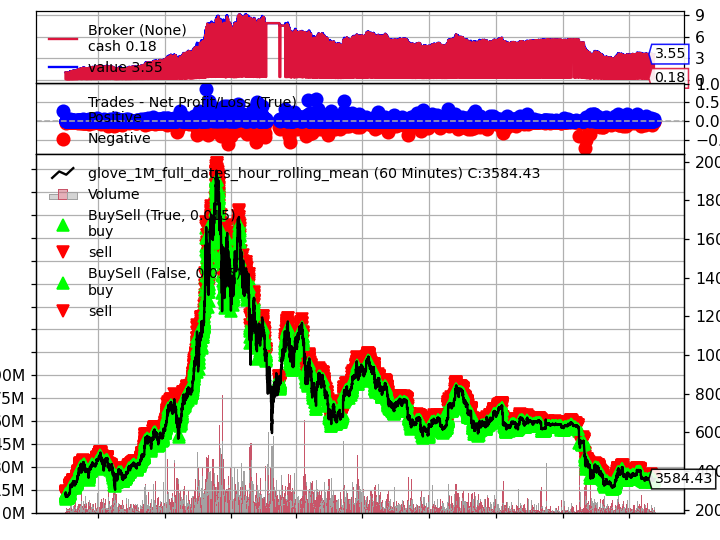

[[<Figure size 640x480 with 4 Axes>]]

In [484]:
#Trading History
cerebro.plot()

In [ ]:
ret_low = returns_fin2.values
ret_mid = returns_fin.values

In [ ]:
#Daily Returns
from matplotlib import pyplot as plt
returns2 = pd.DataFrame(returns_high.values, columns = ['returns'])
returns2.index = returns.index
returns2['datetime'] = returns.index
returns_fin22 = returns2.groupby(['datetime'])['returns'].apply(np.sum)
# plt.title("Daily Returns")
# plt.bar(returns.index, returns_fin)
# plt.hlines(0,returns_fin.index[0],returns_fin.index[-1],color = "black")
# plt.show()

In [ ]:
ret_high = returns_fin22.values

In [ ]:
np.std(ret_high)

In [ ]:
import numpy as np, statsmodels.stats.api as sms

In [ ]:
sms.CompareMeans(ret_high, ret_mid).tconfint_diff(usevar='unequal')

In [ ]:
transactions

In [ ]:
#Transaction Returns
plt.title("Transaction Returns")
plt.bar(transactions.index,transactions['value'])
plt.hlines(0,transactions.index[0],transactions.index[-1],color = "black")
plt.show()

In [ ]:
# Sharpe Ratio
print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())

#### High Mid Low Analysis

In [ ]:
# Low
cerebro.plot()

In [ ]:
# Mid
cerebro.plot()

In [ ]:
#high
cerebro.plot()